# Analyze permutate metrics

Modified from an [@dhimmel](https://github.com/dhimmel) analysis at [`evaluate-permutations.ipynb`](https://github.com/dhimmel/integrate/blob/master/data/permuted/evaluate-permutations.ipynb) 

In [1]:
library(dplyr, warn = FALSE)

In [2]:
# Must manually set
multiplier = 5

In [3]:
stat_file = file.path("..", "hetnets", "permuted", "stats.tsv")
stat_df = readr::read_tsv(stat_file) %>%
  dplyr::mutate(complete = round(complete * multiplier, 2))
head(stat_df, 4)

Parsed with column specification:
cols(
  cumulative_attempts = col_integer(),
  attempts = col_integer(),
  complete = col_double(),
  unchanged = col_double(),
  same_edge = col_double(),
  self_loop = col_integer(),
  duplicate = col_double(),
  undirected_duplicate = col_integer(),
  excluded = col_integer(),
  metaedge = col_character(),
  abbrev = col_character(),
  permutation = col_integer()
)


cumulative_attempts,attempts,complete,unchanged,same_edge,self_loop,duplicate,undirected_duplicate,excluded,metaedge,abbrev,permutation
3606,3607,0.5,0.41134,0.00055448,0,0.082617,0,0,Gene - participates - Cancer-Hallmarks,GpH,1
7212,3606,1.0,0.19506,0.00000000,0,0.095119,0,0,Gene - participates - Cancer-Hallmarks,GpH,1
10818,3606,1.5,0.10855,0.00000000,0,0.090405,0,0,Gene - participates - Cancer-Hallmarks,GpH,1
14424,3606,2.0,0.07334,0.00027732,0,0.079312,0,0,Gene - participates - Cancer-Hallmarks,GpH,1


## How many permutations are needed to randomize an edge 

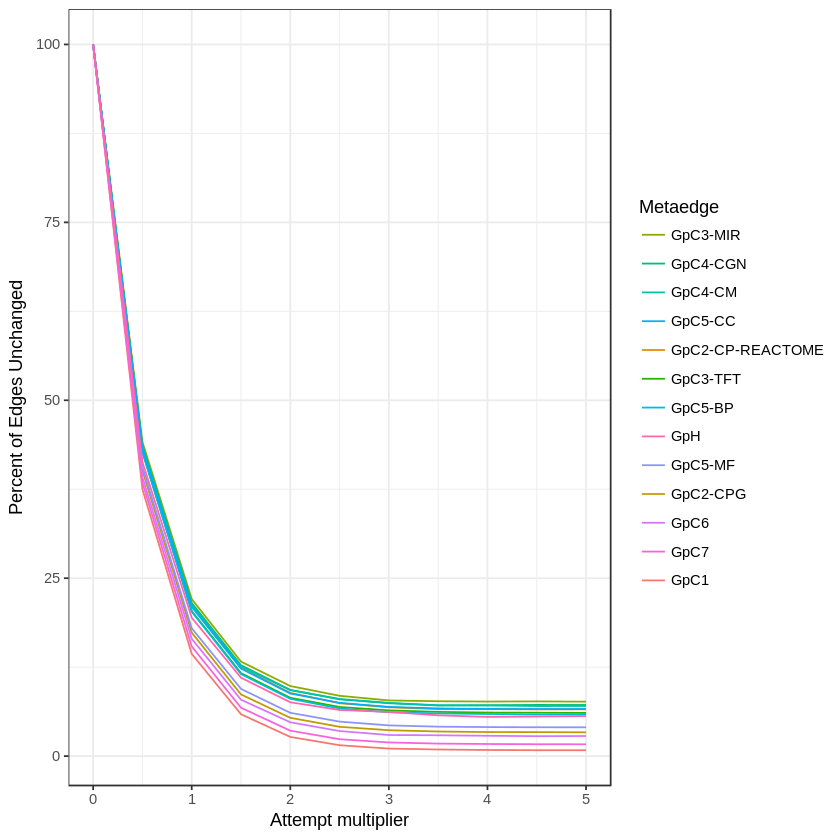

In [4]:
unchanged_df = stat_df %>%
  # Average over permutations
  dplyr::group_by(abbrev, complete) %>%
  dplyr::summarize(unchanged = mean(unchanged)) %>%
  dplyr::ungroup() %>%
  dplyr::bind_rows(dplyr::data_frame(abbrev=unique(stat_df$abbrev), complete = 0, unchanged = 1))

abbrevs = unchanged_df %>%
  dplyr::filter(complete == multiplier) %>%
  dplyr::arrange(desc(unchanged)) %>%
  .[['abbrev']]

unchanged_df %>%
  ggplot2::ggplot(ggplot2::aes(x = complete, y = 100 * unchanged, color = abbrev)) +
  ggplot2::geom_line() +
  ggplot2::theme_bw() +
  ggplot2::scale_colour_discrete(breaks = abbrevs, name='Metaedge') +
  ggplot2::xlab('Attempt multiplier') +
  ggplot2::ylab('Percent of Edges Unchanged')

## What percent of attempts result in a duplicate edge

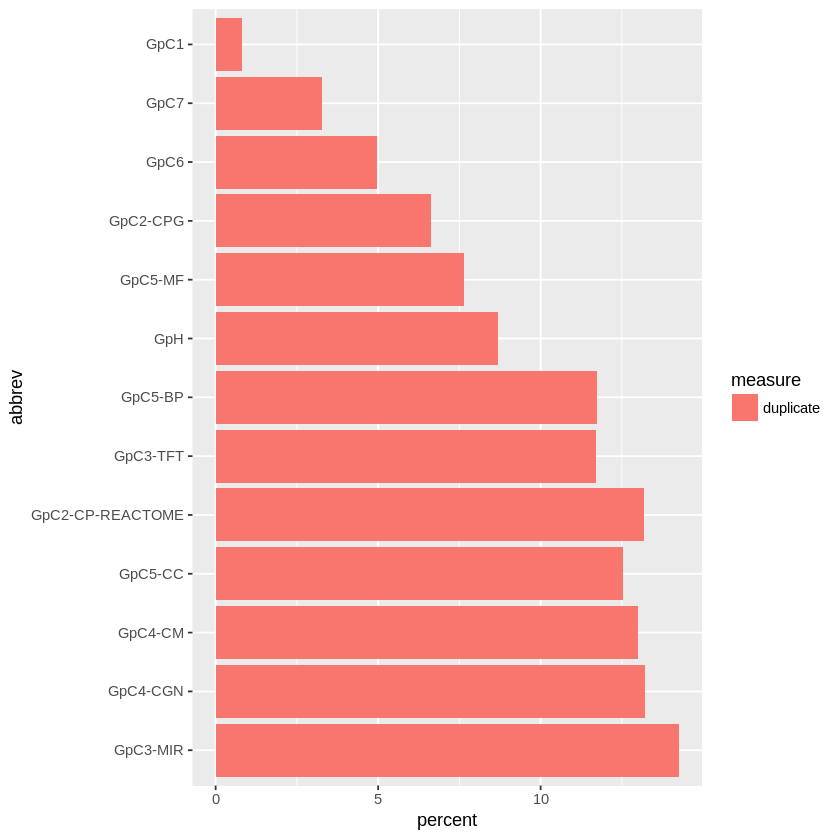

In [5]:
bar_df = stat_df %>%
  tidyr::gather(key = 'measure', value = 'percent', duplicate:excluded, same_edge:undirected_duplicate) %>%
  dplyr::group_by(abbrev, measure) %>%
  dplyr::summarize(
    percent = 100 * weighted.mean(percent, attempts)
  ) %>%
  dplyr::filter(measure != 'excluded')

bar_df$abbrev = factor(bar_df$abbrev, levels=abbrevs)

bar_df %>%
  dplyr::filter(measure %in% c('duplicate')) %>%
  ggplot2::ggplot(ggplot2::aes(x = abbrev, y = percent, fill = measure)) +
  ggplot2::geom_bar(stat = "identity", position = "dodge") +
  ggplot2::coord_flip()

## How frequent are other disqualifying factors for each XSwap attempt

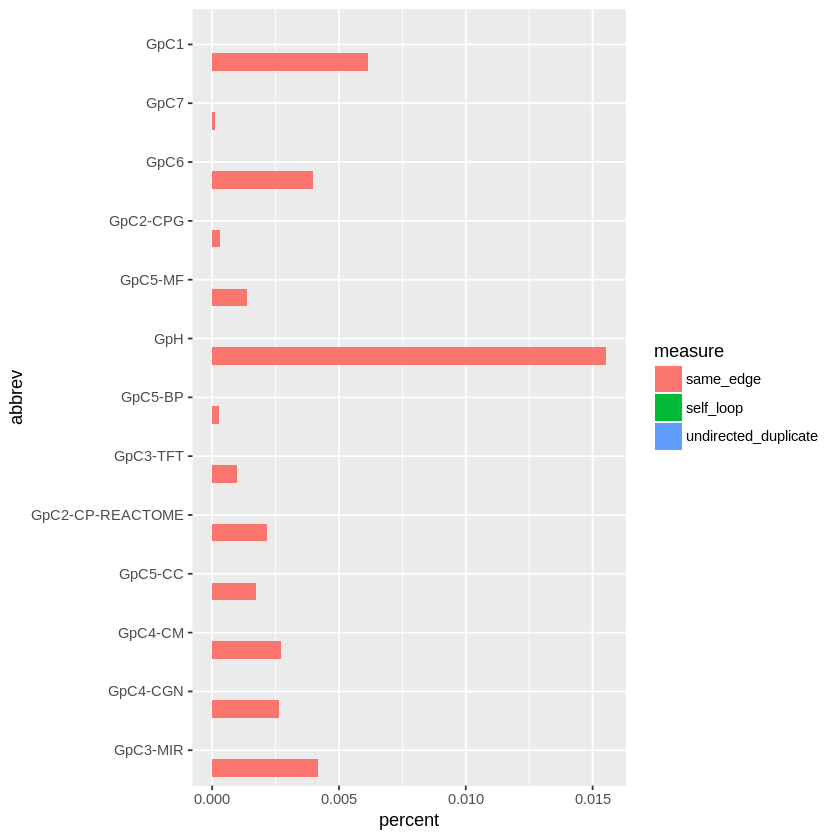

In [6]:
bar_df %>%
  dplyr::filter(!(measure %in% c('duplicate', 'unchanged'))) %>%
  ggplot2::ggplot(ggplot2::aes(x = abbrev, y = percent, fill=measure)) +
  ggplot2::geom_bar(stat = "identity", position = "dodge") +
  ggplot2::coord_flip()